Data Preprocessing & Augmentation (PyTorch)

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

Define transformations for training and validation/test

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale; use 3 values for RGB
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Paths to your data folders

In [4]:
base_path = '../Data/Tumour'
train_dir = f'{base_path}/train'
val_dir = f'{base_path}/valid'
test_dir = f'{base_path}/test'

Create datasets

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

Create DataLoaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 1695
Validation samples: 502
Test samples: 246


Visualize Augmented Sample

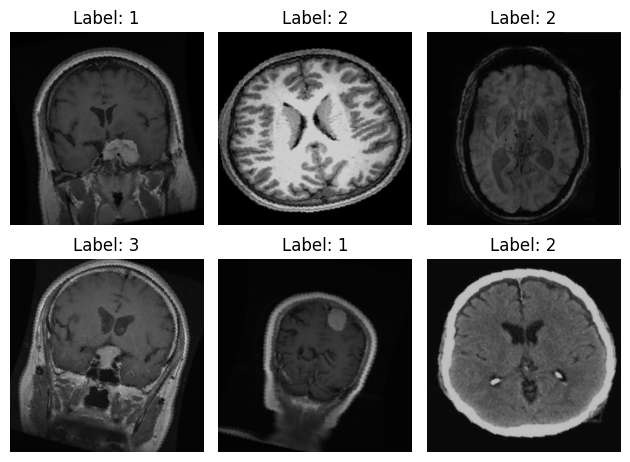

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images (iter returns first batch)
images, labels = next(iter(train_loader))

# Unnormalize and plot first 6 images
for i in range(6):
    img = images[i].numpy().transpose((1, 2, 0))  # add transpose here!
    img = img * 0.5 + 0.5  # unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray' if img.shape[2]==1 else None)
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes
model = model.to(device)

Using device: cpu


c:\Users\ishan\miniconda3\envs\tumour-py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ishan\miniconda3\envs\tumour-py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ishan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training & Validation Loop

In [11]:
num_epochs = 10  

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_corrects.double() / val_total

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 1/10 | Train Loss: 0.5720 | Train Acc: 0.7870 | Val Loss: 0.8548 | Val Acc: 0.7908
Epoch 2/10 | Train Loss: 0.2597 | Train Acc: 0.9032 | Val Loss: 0.4305 | Val Acc: 0.8466
Epoch 3/10 | Train Loss: 0.1692 | Train Acc: 0.9381 | Val Loss: 0.3811 | Val Acc: 0.8625
Epoch 4/10 | Train Loss: 0.1663 | Train Acc: 0.9510 | Val Loss: 0.4179 | Val Acc: 0.8685
Epoch 5/10 | Train Loss: 0.1251 | Train Acc: 0.9587 | Val Loss: 1.1636 | Val Acc: 0.7191
Epoch 6/10 | Train Loss: 0.1249 | Train Acc: 0.9599 | Val Loss: 0.2147 | Val Acc: 0.9382
Epoch 7/10 | Train Loss: 0.1488 | Train Acc: 0.9445 | Val Loss: 0.1861 | Val Acc: 0.9283
Epoch 8/10 | Train Loss: 0.1060 | Train Acc: 0.9587 | Val Loss: 0.1829 | Val Acc: 0.9442
Epoch 9/10 | Train Loss: 0.0720 | Train Acc: 0.9746 | Val Loss: 0.3410 | Val Acc: 0.9104
Epoch 10/10 | Train Loss: 0.0750 | Train Acc: 0.9740 | Val Loss: 0.2269 | Val Acc: 0.9263


In [12]:
torch.save(model.state_dict(), '../models/best_model.pth')
print('Model saved!')

Model saved!


Test Accuracy: 0.9512

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.99      0.97        80
  meningioma       0.95      0.92      0.94        63
    no_tumor       0.92      0.92      0.92        49
   pituitary       0.98      0.96      0.97        54

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



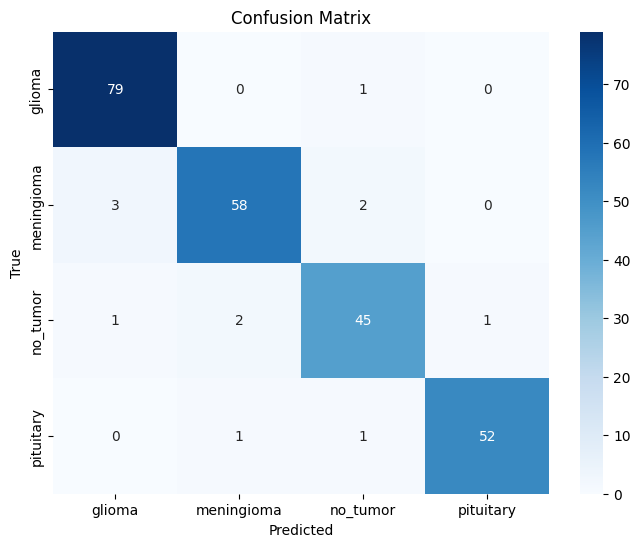

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
target_names = test_dataset.classes  # class names from ImageFolder
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()